In [35]:
import numpy as np

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_distribution
from qiskit_aer import AerSimulator

In [36]:
# Se define el número de qubits de dirección y de datos
num_address_qubits = 2  # Qubits de direccionamiento 
    # (Se pueden codificar 2^2 = 4 ubicaciones)
num_data_qubits = 3     # Qubits para almacenamiento de datos 
    #(cada ubicación tiene 3 qubits de datos)

# Registros cuánticos
address = QuantumRegister(num_address_qubits, name='addr')  # Qubits de dirección
data = QuantumRegister(num_data_qubits, name='data')        # Qubits de datos

# Registros clásicos

# Para medir los qubits de dirección:
meas_address = ClassicalRegister(num_address_qubits, name='medida_addr')

# Para medir los qubits de datos:
meas_data = ClassicalRegister(num_data_qubits, name='medida_data')

# Se crea el circuito QRAM
qram_circuit = QuantumCircuit(address, data, meas_address, meas_data)


In [37]:
# Se definen los datos almacenados (mapeo de datos clásicos a estados cuánticos)
# Ejemplo: Una memoria simple de 4 entradas

stored_data = {
    '00': [1, 0, 1],  # Datos para la dirección 00
    '01': [0, 1, 1],  # Datos para la dirección 01
    '10': [1, 1, 0],  # Datos para la dirección 10
    '11': [1, 1, 1]   # Datos para la dirección 11
}

In [38]:
# Codificación de la QRAM como una "caja-negra".
def qram_unitary():
    qram = QuantumCircuit(num_address_qubits + num_data_qubits, name='   QRAM   ')
    
    for addr, values in stored_data.items():
        addr_bits = [int(bit) for bit in addr]
        control_qubits = []
        
        # Se aplican compuertas X para igualar la dirección (preparando el estado de control)
        for i, bit in enumerate(addr_bits):
            if bit == 0:
                qram.x(i)
                control_qubits.append(i)
        
        # Se aplican compuertas Toffoli con múltiples controles para almacenar los datos
        for j, value in enumerate(values):
            if value == 1:
                qram.mcx(list(range(num_address_qubits)), num_address_qubits + j)
        
        # Se revierten los qubits de control que fueron invertidos
        for qubit in control_qubits:
            qram.x(qubit)
    
    return qram.to_instruction()

In [39]:
# Se aplica la compuerta de Hadamard a los qubits de dirección de entrada
qram_circuit.h(range(num_address_qubits))

# Se agrega al circuito cuántico, la "caja-negra" del bloque de memoria RAM
qram_instruction = qram_unitary()
qram_circuit.append(qram_instruction, address[:] + data[:])

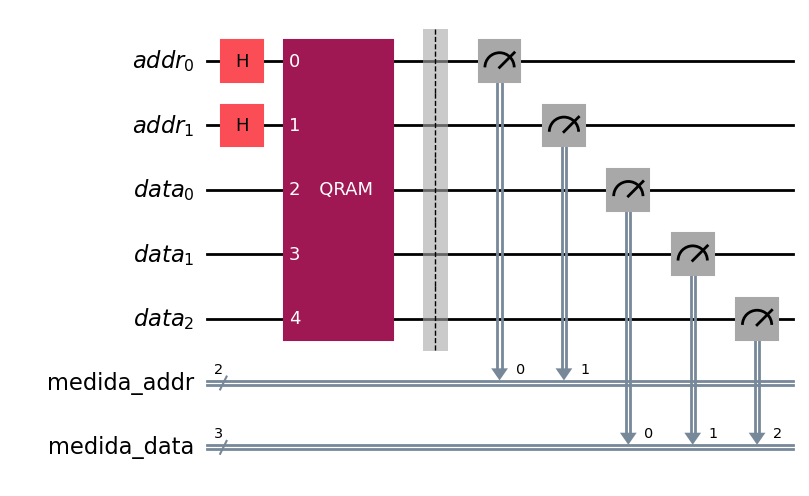

In [40]:
# Medida de los qubits de datos
qram_circuit.barrier()
qram_circuit.measure(address, meas_address)
qram_circuit.measure(data, meas_data)

# Se muestra el circuito
qram_circuit.draw('mpl')

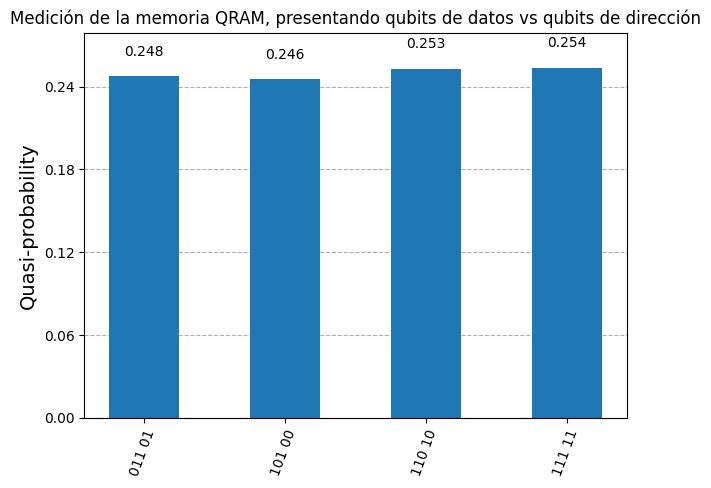

In [41]:
# Simulación del circuito QRAM
simulator = AerSimulator()
result = simulator.run(qram_circuit.decompose(reps=1), shots=10000).result()
counts = result.get_counts()

# Se muestran los resultados de medida
plot_distribution(counts, title='Medición de la memoria QRAM, presentando qubits de datos vs qubits de dirección')